In [1]:
# Import and set up basic packages
import numpy as np

import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 10}) #Basic set up of matplotlib figure and font's size
plt.rcParams["figure.figsize"] = [10, 7]

# Import tools
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Import models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', ValueWarning)


# Import Data

In [2]:
# Create a wrangle function
def wrangle(filepath):
    # Read data from csv file
    df = pd.read_csv(filepath, index_col='Month')

    #Tranform the month column 
    df.index = pd.DatetimeIndex(df.index)

    return df

In [3]:
# Wrangle data from the dataset
df = wrangle('/Data analytics/Projects for portfolio/Air Passenger Time series Python/AirPassengers.csv')

# Explore

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df['#Passengers'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Series name: #Passengers
Non-Null Count  Dtype
--------------  -----
144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
df.isna().sum()

#Passengers    0
dtype: int64

In [7]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
len(df)

144

<Axes: >

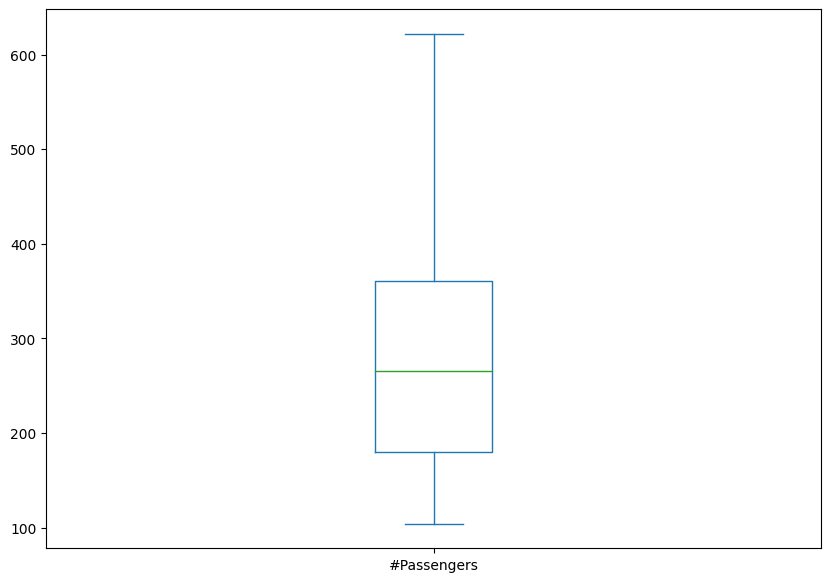

In [9]:
# Box plot
df['#Passengers'].plot(kind='box')

The data doesn't seem to have extreme values/outliers.

<Axes: xlabel='Date'>

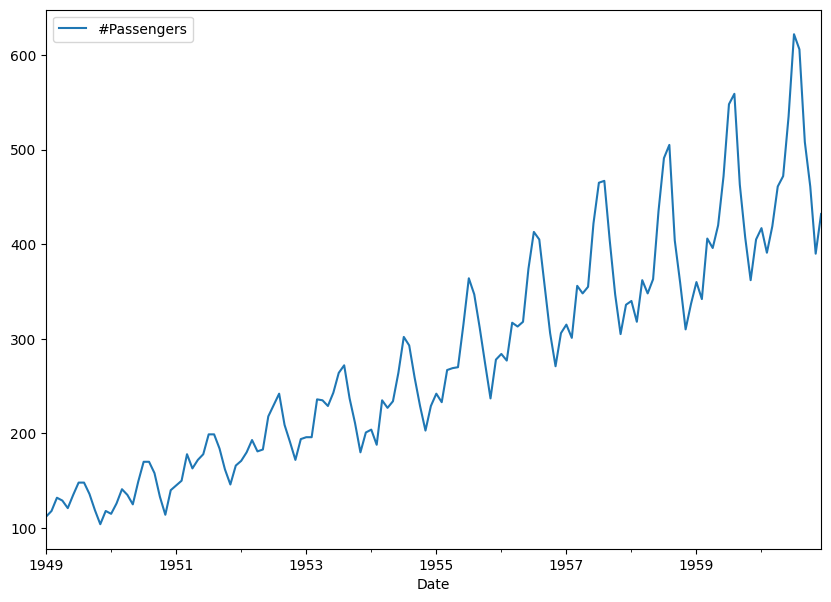

In [10]:
df.plot(xlabel='Date')

<Axes: xlabel='Date'>

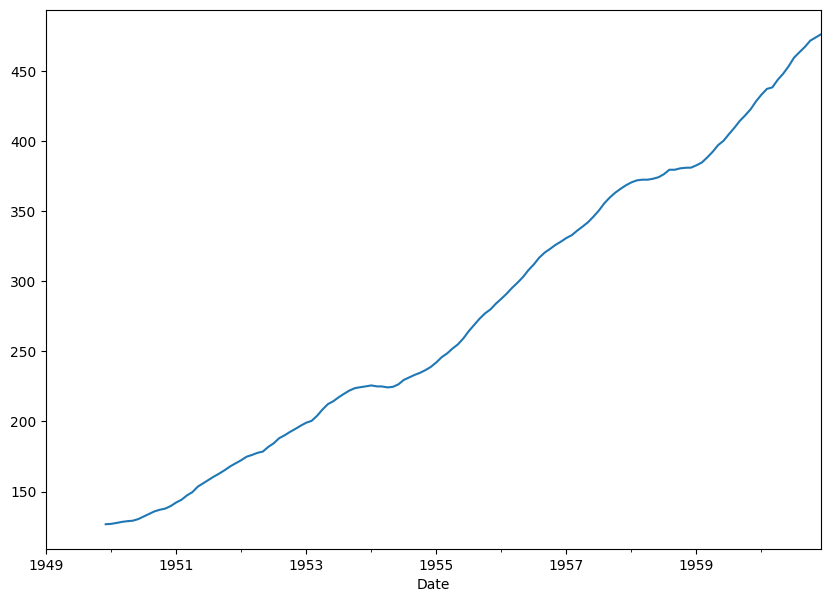

In [11]:
df['#Passengers'].rolling(12).mean().plot(xlabel='Date')

First-look:
* There seems to be a pattern that repeats annually and an upward trend
* Our data is not stationary (changing mean, changing variance)
* The data is showing heteroscedasticity (the standard deviation is not constant), which makes linear regression a bad choice of model.

We will delve deeper later.

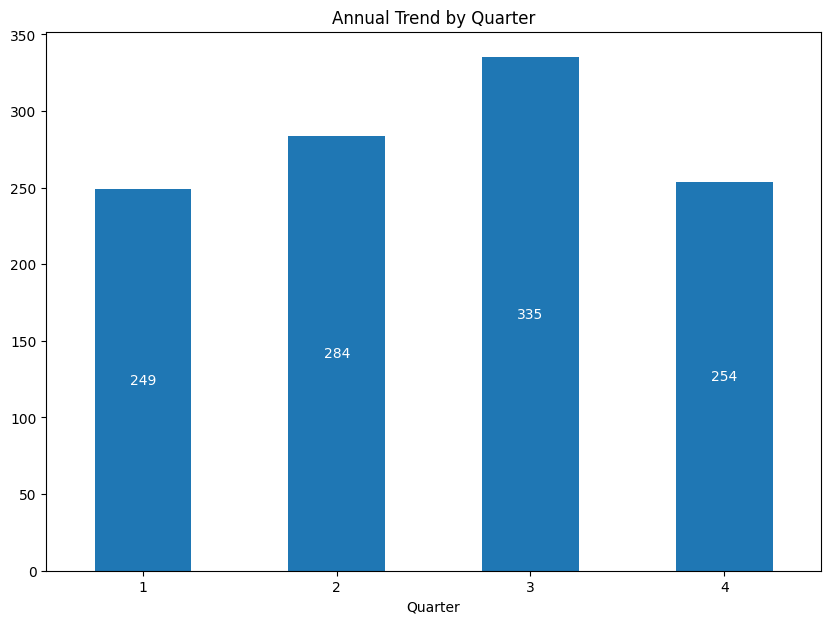

In [12]:
# Annual trend by quarter
annual_tr_quarter = df['#Passengers'].groupby(df['#Passengers'].index.quarter).mean().round()
atq = annual_tr_quarter.plot(kind = 'bar',
                       xlabel = 'Quarter',
                       title='Annual Trend by Quarter')
plt.bar_label(atq.containers[0], label_type='center', color='white')
plt.xticks(rotation=0);

<Axes: title={'center': 'Annual Trend by Month'}, xlabel='Month'>

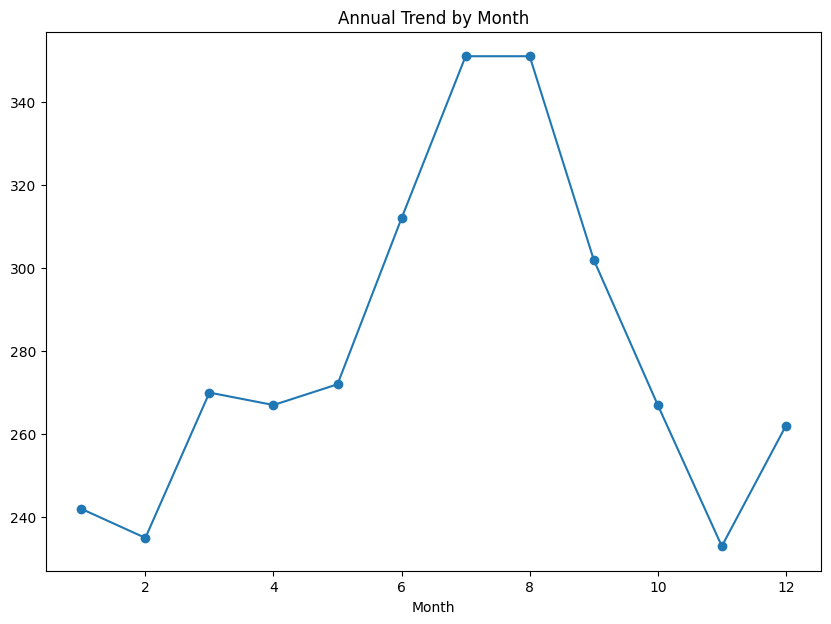

In [13]:
# Annual trend by month
annual_tr_month = df['#Passengers'].groupby(df['#Passengers'].index.month).mean().round()
annual_tr_month.plot(title='Annual Trend by Month', marker='o')

The data follows a general pattern that we usually observe in years that are not influenced by extreme economic conditions, travel restrictions, etc.
* Big spikes in the summer (starting from June to August) due to summer vacations and a high demand for leisure travel:
    * June marks the beginning of the vacation season
    * July is the peak travel month
    * The end of August is when the vacation season starts to end for many people
* There are also small spikes:
    * March is when students and families have trips due to students having Spring break
    * December is the holiday season with Christmas at the end of the month and New Year's right after

In [14]:
# Create a function to decompose time-series dataframe
def decomposer(ts_dataframe):
    decompose = seasonal_decompose(ts_dataframe, model='additive')
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 7))
    decompose.observed.plot(ylabel='Observed', ax=ax[0])
    decompose.trend.plot(ylabel='Trend', ax=ax[1])
    decompose.seasonal.plot(ylabel='Seasonal', ax=ax[2])
    decompose.resid.plot(ylabel='Resid', ax=ax[3])
    
    plt.xlabel('Date')

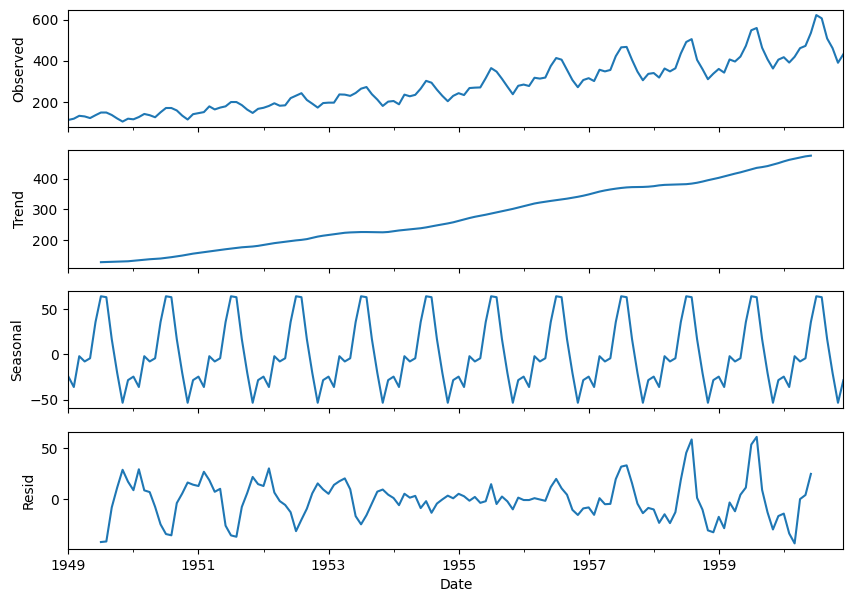

In [15]:
# Decompose our time series
decomposer(df)

A few things that we can draw from the decomposer:
* There is a noticable upward trend
* There is seasonality, which will make SARIMA a better choice than ARIMA
* Residual plot doesn't show any trend or seasonality, so the decomposer is working fine

In [16]:
# Create a function to test the stationarity of the time-series
def stationarity_test(series):
    result = adfuller(series)
    p_val = result[1]

    # Interpret test result
    if p_val < 0.05:
        print('The time-series is stationary (reject the null hypothesis).')
    else:
        print('The time-series is non-stationary (fail to reject the null hypothesis).')

<Axes: xlabel='Date'>

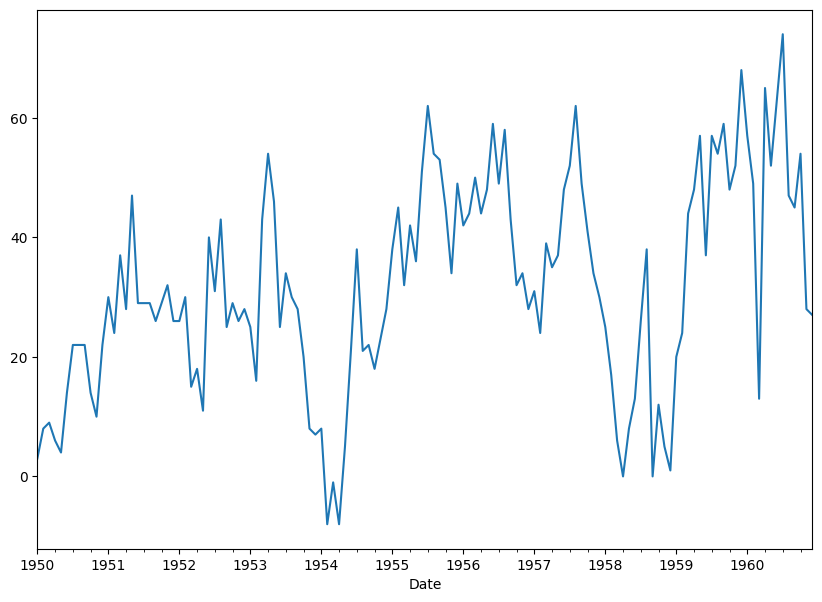

In [17]:
# First-order seasonal differencing (for the parameter D)
diff_1s = df['#Passengers'].diff(12).dropna()
diff_1s.plot(xlabel='Date')

The first seasonal difference is still seasonal, plus, there still appears to be a trend in our differenced time-series. An additional non-seasoning differencing is needed.

<Axes: xlabel='Date'>

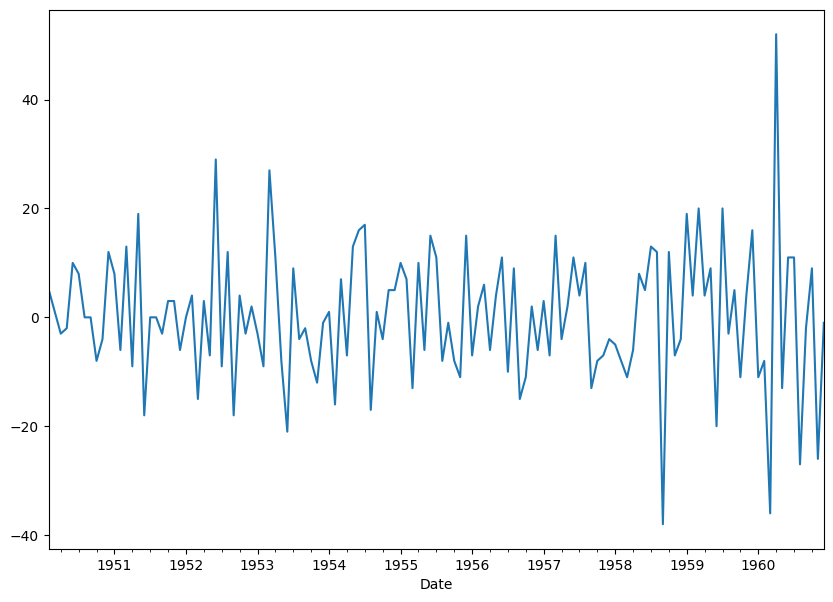

In [18]:
# Additional non-seasonal differencing (for the parameter d)
diff_1s_1r = diff_1s.diff(1).dropna()
diff_1s_1r.plot(xlabel='Date')

It looks random enough with a constant mean around 0.

In [19]:
# Stationarity test using adfuller
stationarity_test(diff_1s_1r.values)

The time-series is stationary (reject the null hypothesis).


In [20]:
p_val = adfuller(diff_1s_1r.values)[1]
p_val

1.8565116001234705e-28

Our diffed time-series is now stationary. I think the potential model should be ARIMA(p,1,q)x(P,1,Q)12.

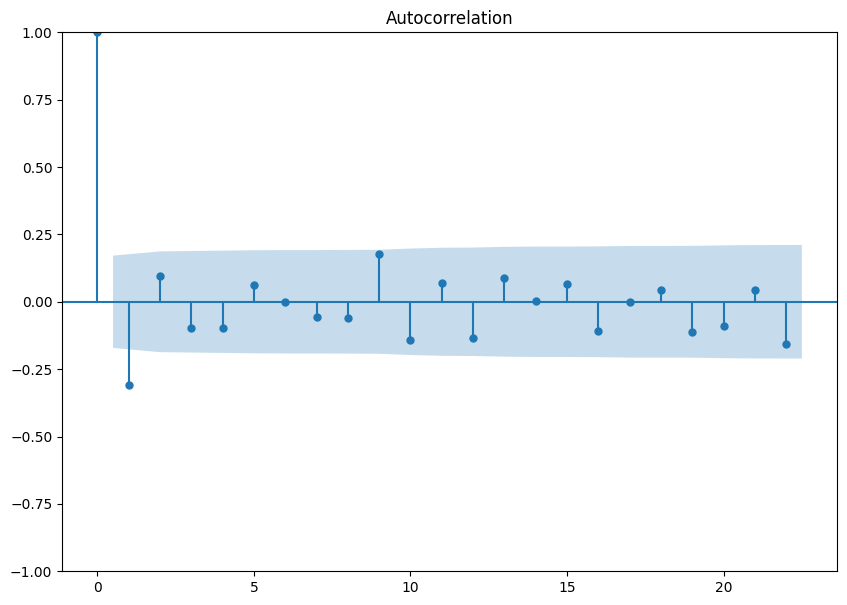

In [21]:
# ACF plot
plot_acf(diff_1s_1r);

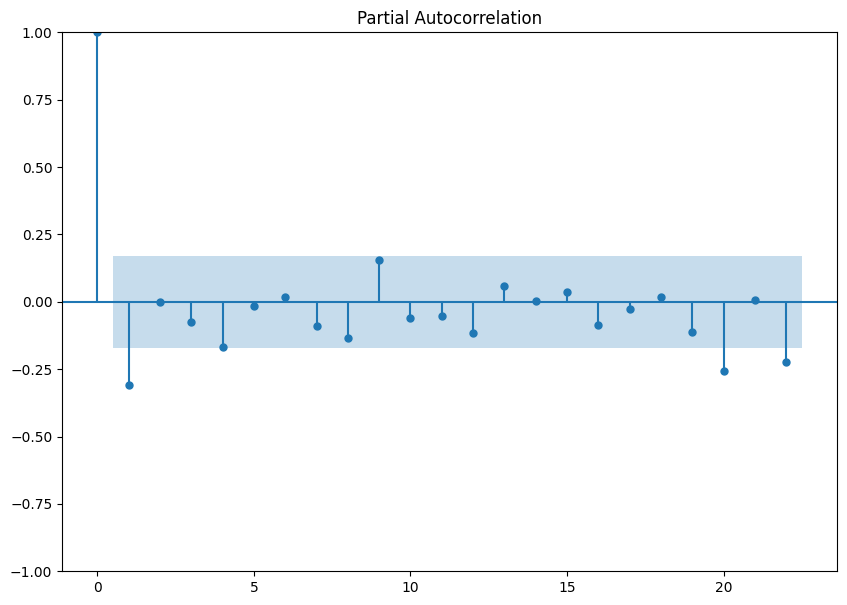

In [22]:
# PACF plot
plot_pacf(diff_1s_1r);

Our p and P should fall into either 0 or 1. Addtionally, adding a moving average may or may not be needed, so q and Q should be in a range of 0 to 1. It's safe to say the best model for our data is something like this:
ARIMA([0-1] ,1 ,[0-1]) x ([0-1], 1, [0-1]) 12

# Build Model

## Split

In [23]:
# Split
y = df['#Passengers']
cutoff_split = int(len(y)*0.8)
y_train = y.iloc[:cutoff_split]
y_test = y.iloc[cutoff_split:]

## Baseline

In [24]:
# Base MSE
y_pred_baseline = [y_train.mean()]*len(y_train)
y_train_mse = mean_squared_error(y_train, y_pred_baseline)
print(f'Base MSE: {y_train_mse}')

Base MSE: 8271.858147448016


## Iterate

In [25]:
# Find the best parameters using Auto Arima but based on our potential model
arima = auto_arima(y_train,
                   start_p=0, max_p= 1,
                   d=1, max_d= 1,
                   start_q=0, max_q= 1,
                   start_P=0, max_P= 1,
                   D=1,max_D= 1,
                   start_Q=0, max_Q= 1,
                   m=12,
                   seasonal=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   n_fits=100,
                   trace=True
                   )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.166, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=758.107, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=756.629, Time=0.20 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=756.406, Time=0.17 sec
 ARIMA(1,1

In [26]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Sun, 13 Aug 2023   AIC                            755.499
Time:                                    04:46:54   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Find the best parameters using Auto Arima but based on our potential model
free_arima = auto_arima(y_train,
                   start_p=0, max_p= 3, # Bigger range will let us find better but more complex model
                   d=1, max_d= 1,
                   start_q=0, max_q= 3,
                   start_P=0, max_P= 3,
                   D=1,max_D= 1,
                   start_Q=0, max_Q= 3,
                   m=12,
                   seasonal=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   n_fits=100,
                   trace=True
                   )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.42 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.16 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.60 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=1.83 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.33 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.32 sec
 ARIMA(0,1,1)(0,1,0)[1

In [28]:
free_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Sun, 13 Aug 2023   AIC                            752.557
Time:                                            04:48:15   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As expected, the "free" model has a higher accuracy (lower AIC indicates better fit), but it is also more complex (higher BIC indicates the higher complexity).

I can do further evaluation but generally it's not worth the time, since the difference in accuracy is low. The decision of whether or not which would be the better model is more than just a simple trade off between model's accuracy and simplicity. Other factors such as domain expertise and context should be taken in account as well.

I will proceed with the simple model as it aligns with my ACF and PACF analysis.

<Axes: xlabel='Date'>

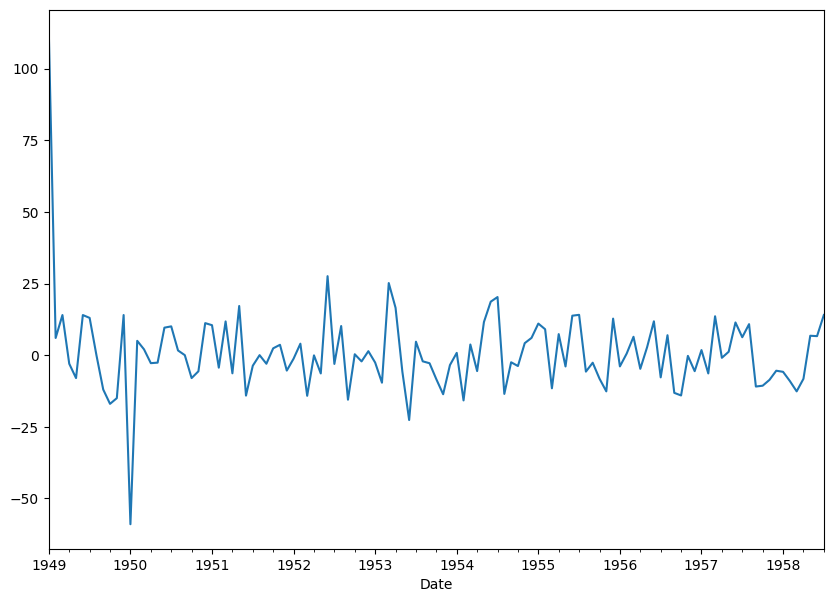

In [29]:
# Plot residuals to check for trends or patterns
arima.resid().plot(xlabel='Date')

The residuals plots look good as there is no trend or patterns.

## Evaluate

In [30]:
# Rolling validation (walk-forward validation)
test_size = int(len(y_test))
prediction = []
for i in range(test_size):
    train = y.iloc[:-(test_size-i)]
    model = SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
    next_pred = model.forecast(steps=1)
    prediction.append(next_pred.iloc[0])

y_wfv = pd.Series(prediction, index=y_test.index)
y_wfv.head()

Month
1958-08-01    490.337911
1958-09-01    439.772881
1958-10-01    355.658336
1958-11-01    314.133631
1958-12-01    342.701854
dtype: float64

In [31]:
# Comparison between models' MSEs and Baseline model's MSE
print(f'Base MSE: {round(y_train_mse, 2)}')

y_wfv_mse = mean_squared_error(y_test, y_wfv)
print(f'Test MSE: {round(y_wfv_mse, 2)}')

Base MSE: 8271.86
Test MSE: 301.0


# Communicate Results

In [32]:
# Create a DataFrame from y_test and y_wfv for easier comparison
y_test_and_pred = pd.DataFrame({
    'y_test': y_test,
    'y_wfv': y_wfv,
})
y_test_and_pred.head()

,y_test,y_wfv
Month,,
1958-08-01,505,490.337911
1958-09-01,404,439.772881
1958-10-01,359,355.658336
1958-11-01,310,314.133631
1958-12-01,337,342.701854


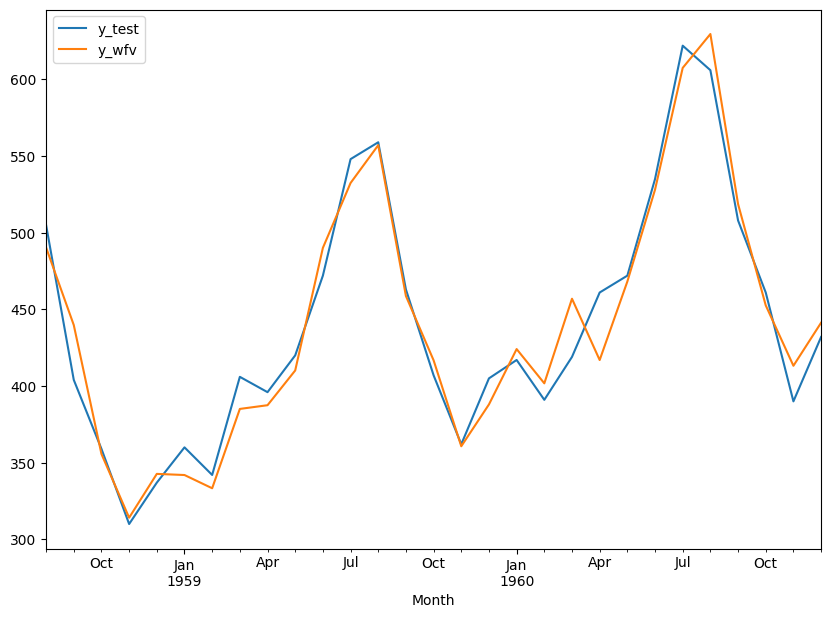

In [33]:
# Visual comparison of y_test and y_wfv
y_test_and_pred.plot()
plt.legend(loc='upper left');

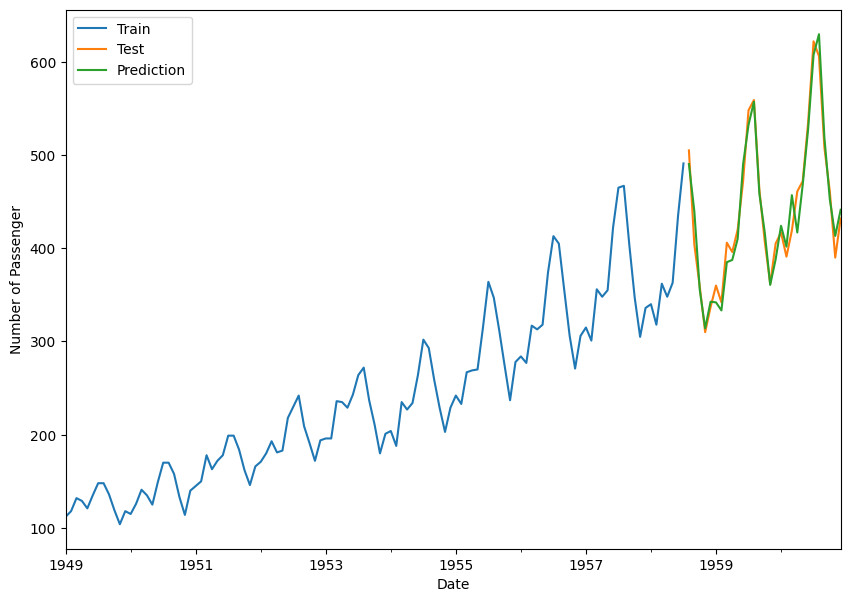

In [34]:
# Visualization of true data and model's prediction
plt.figure()
y_train.plot(label='Train')
y_test.plot(label='Test')
y_wfv.plot(label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Passenger')
plt.legend();

# Save, Load, and Test Model

In [35]:
# Save model
model = SARIMAX(y_train, order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
modelname = 'air_passenger_SARIMAX.pkl'
joblib.dump(model, modelname)

['air_passenger_SARIMAX.pkl']

In [36]:
# Load model
modelname = 'air_passenger_SARIMAX.pkl'
sarima_model = joblib.load(modelname)

In [37]:
# Test model
import datetime as dt
today = dt.datetime.now()
last_month = today - dt.timedelta(days=30)

from ts_predictor import Air_Passenger_Predictor # Load the predictor that we have defined in predictor.py
Air_Passenger_Predictor(modelname, last_month, today, return_series=True)

2023-08-01    2036.713050
2023-09-01    1974.258182
Freq: MS, Name: predicted_mean, dtype: float64